## 最適制御問題

In [1]:
import jax
import jax.numpy as jnp

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from jax.example_libraries import optimizers
from tqdm.notebook import trange
from functools import partial

### 準備

In [2]:
delta = 0.05
beta = 20.0
N = 100
T = 1.0
train_itr = 200

### 放射基底関数の定義

In [3]:
def rbf(x, beta):
    return jnp.exp(-beta*x**2)

In [4]:
@jax.jit
def rbf_func(x, theta):
    s = 0.
    for i in range(len(theta)):
        s +=theta[i] * rbf(x - delta*i+0.5, beta)
    return s

### 微分可能数値積分モジュールの定義

In [5]:
def Integrate(T, N, theta):
    dt = T/N
    J = 0.
    x = 1.
    for i in range(N):
        u = rbf_func(i*dt, theta)
        x += u*dt
        F = x**2 + u**2
        J += F*dt
    return J

### 学習

In [6]:
adam_lr = 0.1
opt_init, opt_update, get_params = optimizers.adam(adam_lr)

def step(T, N, step_num, opt_state):
    value, grads = jax.value_and_grad(Integrate, argnums=-1)(T, N, get_params(opt_state))
    new_opt_state = opt_update(step_num, grads, opt_state)
    return value, new_opt_state

def train(T, N, theta):
    opt_state = opt_init(theta)
    for itr in trange(train_itr, leave=False):
        value, opt_state = step(T, N, itr, opt_state)
        print("\r"+"\rloss:{}".format(value), end=" ")
    return get_params(opt_state)

In [7]:
theta_init = jnp.ones(50)
theta_trained = train(T, N, theta_init)

  0%|          | 0/200 [00:00<?, ?it/s]

loss:0.7586945295333862 

### 厳密解との比較

In [8]:
ts = jnp.arange(0,1,1/len(theta_init))
df = pd.DataFrame()
df["t"] = ts
df["Exact"] = [float(-jnp.sinh(1-t)/jnp.cosh(1.)) for t in ts]
df["DU-VO"] = [float(rbf_func(t, theta_trained)) for t in ts]

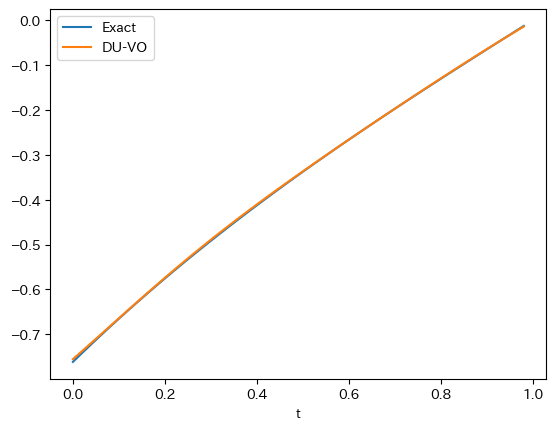

In [9]:
df.plot("t", df.columns[1:]);